# 序列模型

In [43]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils import data
import random
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

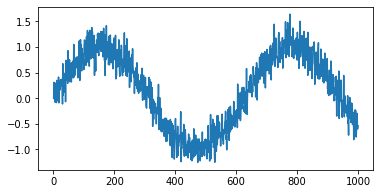

In [23]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(6, 3))
plt.plot(time, x);

In [10]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [12]:
features[:, 0]

tensor([-7.0508e-02, -4.2369e-02,  9.5203e-02,  1.4816e-01,  3.1419e-02,
         2.1928e-01, -7.6425e-02,  3.2875e-01,  2.4423e-01,  4.3641e-01,
         2.6379e-01,  9.8312e-02,  2.5582e-01,  1.8730e-01,  1.1882e-01,
         3.6570e-01, -5.4478e-02,  6.5845e-02,  5.3693e-02,  1.0587e-01,
         2.4270e-01,  5.2036e-01,  3.0574e-01, -1.1154e-01,  3.7939e-01,
         3.4618e-01, -7.3885e-02,  4.6977e-01,  1.4062e-01,  6.5418e-01,
         1.3038e-01,  3.6412e-01,  4.7819e-01,  1.6694e-01,  3.5818e-01,
         5.3351e-01,  2.0016e-01, -6.1633e-02,  4.7912e-01,  6.1069e-01,
         2.9831e-01,  3.5183e-01,  5.5273e-01,  8.1606e-01,  5.1125e-01,
         2.9319e-01,  5.6200e-01,  4.2322e-01,  4.0219e-01,  2.8489e-01,
         7.0692e-01,  5.1870e-01,  3.0233e-01,  6.8473e-01,  3.2504e-01,
         3.9187e-01,  6.1044e-01,  3.8401e-01,  6.8098e-01,  6.7048e-01,
         2.2665e-01,  9.7189e-01,  7.2451e-01,  4.1304e-01,  5.9426e-01,
         8.1344e-01,  5.8271e-01,  3.2546e-01,  8.1

In [13]:
features

tensor([[-0.0705, -0.0424,  0.0952,  0.1482],
        [-0.0424,  0.0952,  0.1482,  0.0314],
        [ 0.0952,  0.1482,  0.0314,  0.2193],
        ...,
        [-0.6041, -0.4297, -0.6030, -0.6707],
        [-0.4297, -0.6030, -0.6707, -0.4798],
        [-0.6030, -0.6707, -0.4798, -0.9198]])

In [14]:
labels

tensor([[ 3.1419e-02],
        [ 2.1928e-01],
        [-7.6425e-02],
        [ 3.2875e-01],
        [ 2.4423e-01],
        [ 4.3641e-01],
        [ 2.6379e-01],
        [ 9.8312e-02],
        [ 2.5582e-01],
        [ 1.8730e-01],
        [ 1.1882e-01],
        [ 3.6570e-01],
        [-5.4478e-02],
        [ 6.5845e-02],
        [ 5.3693e-02],
        [ 1.0587e-01],
        [ 2.4270e-01],
        [ 5.2036e-01],
        [ 3.0574e-01],
        [-1.1154e-01],
        [ 3.7939e-01],
        [ 3.4618e-01],
        [-7.3885e-02],
        [ 4.6977e-01],
        [ 1.4062e-01],
        [ 6.5418e-01],
        [ 1.3038e-01],
        [ 3.6412e-01],
        [ 4.7819e-01],
        [ 1.6694e-01],
        [ 3.5818e-01],
        [ 5.3351e-01],
        [ 2.0016e-01],
        [-6.1633e-02],
        [ 4.7912e-01],
        [ 6.1069e-01],
        [ 2.9831e-01],
        [ 3.5183e-01],
        [ 5.5273e-01],
        [ 8.1606e-01],
        [ 5.1125e-01],
        [ 2.9319e-01],
        [ 5.6200e-01],
        [ 4

In [17]:
batch_size, n_train = 16, 600
train_iter = data.DataLoader(data.TensorDataset(features[:n_train], labels[:n_train]), batch_size=batch_size, shuffle=True)

In [18]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net


loss = nn.MSELoss(reduction='none')

In [29]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    net.to('cuda')
    for epoch in range(epochs):
        loss_sum = 0
        cnt = 0
        for X, y in train_iter:
            X = X.to('cuda')
            y = y.to('cuda')
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            loss_sum += l.detach().sum().cpu()
            cnt += X.shape[0]
            trainer.step()
        print(f'epoch {epoch + 1}, ', f'loss: {loss_sum / cnt:f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,  loss: 0.126391
epoch 2,  loss: 0.051814
epoch 3,  loss: 0.050376
epoch 4,  loss: 0.050937
epoch 5,  loss: 0.049636


In [30]:
onestep_preds = net(features.to('cuda')).cpu()
onestep_preds

tensor([[-0.0261],
        [ 0.0426],
        [ 0.0914],
        [ 0.1008],
        [ 0.0539],
        [ 0.1640],
        [ 0.1744],
        [ 0.3420],
        [ 0.3099],
        [ 0.2904],
        [ 0.2116],
        [ 0.1817],
        [ 0.2219],
        [ 0.1853],
        [ 0.1250],
        [ 0.1380],
        [-0.0034],
        [ 0.0797],
        [ 0.1680],
        [ 0.2941],
        [ 0.3179],
        [ 0.2976],
        [ 0.2099],
        [ 0.1657],
        [ 0.2550],
        [ 0.2290],
        [ 0.1926],
        [ 0.3908],
        [ 0.3231],
        [ 0.4236],
        [ 0.3125],
        [ 0.3719],
        [ 0.3844],
        [ 0.3421],
        [ 0.3414],
        [ 0.2939],
        [ 0.2567],
        [ 0.3030],
        [ 0.4908],
        [ 0.4718],
        [ 0.4811],
        [ 0.5610],
        [ 0.6236],
        [ 0.5934],
        [ 0.4769],
        [ 0.4562],
        [ 0.4762],
        [ 0.4470],
        [ 0.4890],
        [ 0.4862],
        [ 0.5797],
        [ 0.4998],
        [ 0.

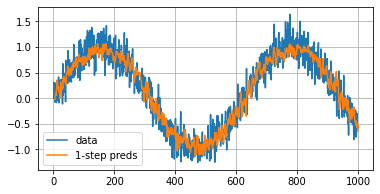

In [32]:
plt.figure(figsize=(6, 3))
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), label='1-step preds')
plt.grid()
plt.legend();

In [38]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)).to('cuda')).cpu()
multistep_preds.shape, n_train
# len(time[n_train+tau])

(torch.Size([1000]), 600)

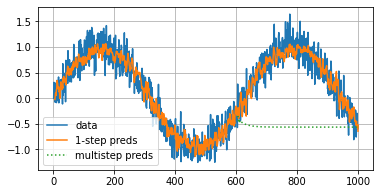

In [41]:
plt.figure(figsize=(6, 3))
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), label='1-step preds')
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(),
         label='multistep preds', linestyle='dotted')
plt.grid()
plt.legend();

In [42]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
features.shape

torch.Size([933, 68])

In [43]:
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

In [46]:
features

tensor([[-0.0015,  0.3073, -0.0135,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3073, -0.0135, -0.0199,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0135, -0.0199,  0.1301,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3531,  0.2327,  0.2984,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2327,  0.2984,  0.1018,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2984,  0.1018,  0.1904,  ...,  0.0000,  0.0000,  0.0000]])

In [51]:
i = 5
features[:, i - tau:i].shape

torch.Size([933, 4])

In [54]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i].to('cuda')).cpu().reshape(-1)
features[:, 1]

tensor([ 3.0726e-01, -1.3465e-02, -1.9902e-02,  1.3006e-01, -7.9840e-02,
         2.9229e-01,  7.6815e-02,  4.8948e-02, -8.7692e-02, -4.1431e-02,
         3.4576e-01,  1.0027e-01, -2.6867e-02,  1.7983e-01, -5.0760e-02,
         4.1203e-01, -9.2479e-02,  1.9120e-01,  2.1841e-01,  1.6928e-01,
         1.5912e-01,  3.5284e-01,  3.5595e-01,  3.4895e-01,  2.9644e-01,
         3.6695e-01,  2.3053e-01,  2.3364e-01, -1.1359e-01,  6.7152e-01,
         5.2746e-02,  4.7770e-01,  2.9729e-01,  3.6315e-01,  2.1455e-01,
         3.5681e-01,  1.1715e-01,  4.9155e-01, -7.0341e-02,  7.3655e-01,
         3.4609e-01,  5.2815e-01,  4.0522e-01,  7.3018e-01,  6.3598e-01,
         2.8829e-01,  9.2581e-01,  3.5878e-01,  4.8511e-01,  4.8534e-01,
         5.3156e-01,  7.4768e-01,  3.1892e-01,  4.6328e-01,  4.6372e-01,
         5.4793e-01,  6.6742e-01,  3.1487e-01,  6.9241e-01,  4.2861e-01,
         6.2668e-01,  4.9944e-01,  7.2199e-01,  3.9364e-01,  5.2106e-01,
         1.0479e+00,  4.1040e-01,  6.5183e-01,  4.4

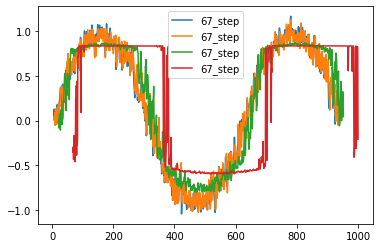

In [56]:
steps = (1, 4, 16, 64)
for step in steps:
    plt.plot(time[tau + step - 1:T - max_steps + step], features[:, tau + step - 1].detach().numpy(), label=f'{i}_step')
plt.legend();

# 文本预处理

In [11]:

import re
from d2l import torch as d2l

ModuleNotFoundError: No module named 'collection'

In [4]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')
d2l.download('time_machine')

'..\\data\\timemachine.txt'

In [6]:
txt_path = '../data/timemachine.txt'


def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

In [7]:
lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [8]:
lines[0]

'the time machine by h g wells'

In [9]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [10]:
for line in tokens:
    if '<unk>' in line:
        print(line)

In [12]:
class Vocab:  #@save
    """文本词表"""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [13]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [18]:
tokens

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells'],
 [],
 [],
 [],
 [],
 ['i'],
 [],
 [],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him'],
 ['was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us',
  'his',
  'grey',
  'eyes',
  'shone',
  'and'],
 ['twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated',
  'the'],
 ['fire',
  'burned',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent'],
 ['lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and'],
 ['passed',
  'in',
  'our',
  'glasses',
  'our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and'],
 ['caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that'],
 ['luxurious',
  'after',
  'dinner',

In [16]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [59]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)
# vocab

(170580, 28)

# 语言模型和数据集

In [35]:
tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
corpus

['the',
 'time',
 'machine',
 'by',
 'h',
 'g',
 'wells',
 'i',
 'the',
 'time',
 'traveller',
 'for',
 'so',
 'it',
 'will',
 'be',
 'convenient',
 'to',
 'speak',
 'of',
 'him',
 'was',
 'expounding',
 'a',
 'recondite',
 'matter',
 'to',
 'us',
 'his',
 'grey',
 'eyes',
 'shone',
 'and',
 'twinkled',
 'and',
 'his',
 'usually',
 'pale',
 'face',
 'was',
 'flushed',
 'and',
 'animated',
 'the',
 'fire',
 'burned',
 'brightly',
 'and',
 'the',
 'soft',
 'radiance',
 'of',
 'the',
 'incandescent',
 'lights',
 'in',
 'the',
 'lilies',
 'of',
 'silver',
 'caught',
 'the',
 'bubbles',
 'that',
 'flashed',
 'and',
 'passed',
 'in',
 'our',
 'glasses',
 'our',
 'chairs',
 'being',
 'his',
 'patents',
 'embraced',
 'and',
 'caressed',
 'us',
 'rather',
 'than',
 'submitted',
 'to',
 'be',
 'sat',
 'upon',
 'and',
 'there',
 'was',
 'that',
 'luxurious',
 'after',
 'dinner',
 'atmosphere',
 'when',
 'thought',
 'roams',
 'gracefully',
 'free',
 'of',
 'the',
 'trammels',
 'of',
 'precision',


In [22]:
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [24]:
freqs = [freq for token, freq in vocab.token_freqs]
freqs

[2261,
 1267,
 1245,
 1155,
 816,
 695,
 552,
 541,
 443,
 440,
 437,
 354,
 281,
 270,
 243,
 221,
 216,
 204,
 200,
 158,
 152,
 137,
 137,
 134,
 129,
 127,
 123,
 122,
 122,
 122,
 120,
 118,
 114,
 114,
 113,
 113,
 112,
 106,
 105,
 103,
 94,
 93,
 92,
 92,
 91,
 89,
 88,
 87,
 86,
 85,
 85,
 85,
 84,
 84,
 82,
 79,
 77,
 75,
 74,
 74,
 74,
 73,
 72,
 71,
 70,
 70,
 70,
 69,
 66,
 62,
 61,
 60,
 59,
 59,
 57,
 57,
 57,
 55,
 54,
 54,
 53,
 52,
 51,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 48,
 47,
 47,
 46,
 46,
 46,
 46,
 45,
 45,
 44,
 43,
 43,
 43,
 42,
 42,
 41,
 40,
 40,
 40,
 40,
 39,
 38,
 38,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 33,
 33,
 32,
 32,
 32,
 32,
 32,
 31,
 31,
 31,
 30,
 30,
 30,
 29,
 29,
 28,
 28,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 24,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 

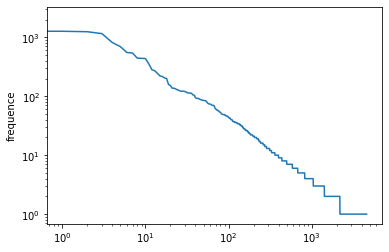

In [32]:
plt.plot(freqs)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('frequence');

In [33]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]

In [34]:
bigram_tokens

[('the', 'time'),
 ('time', 'machine'),
 ('machine', 'by'),
 ('by', 'h'),
 ('h', 'g'),
 ('g', 'wells'),
 ('wells', 'i'),
 ('i', 'the'),
 ('the', 'time'),
 ('time', 'traveller'),
 ('traveller', 'for'),
 ('for', 'so'),
 ('so', 'it'),
 ('it', 'will'),
 ('will', 'be'),
 ('be', 'convenient'),
 ('convenient', 'to'),
 ('to', 'speak'),
 ('speak', 'of'),
 ('of', 'him'),
 ('him', 'was'),
 ('was', 'expounding'),
 ('expounding', 'a'),
 ('a', 'recondite'),
 ('recondite', 'matter'),
 ('matter', 'to'),
 ('to', 'us'),
 ('us', 'his'),
 ('his', 'grey'),
 ('grey', 'eyes'),
 ('eyes', 'shone'),
 ('shone', 'and'),
 ('and', 'twinkled'),
 ('twinkled', 'and'),
 ('and', 'his'),
 ('his', 'usually'),
 ('usually', 'pale'),
 ('pale', 'face'),
 ('face', 'was'),
 ('was', 'flushed'),
 ('flushed', 'and'),
 ('and', 'animated'),
 ('animated', 'the'),
 ('the', 'fire'),
 ('fire', 'burned'),
 ('burned', 'brightly'),
 ('brightly', 'and'),
 ('and', 'the'),
 ('the', 'soft'),
 ('soft', 'radiance'),
 ('radiance', 'of'),
 ('of', 

In [37]:
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [38]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

In [39]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

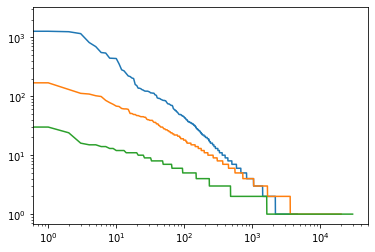

In [40]:
plt.plot(freqs,label='unigram')
plt.plot(bigram_freqs,label='bigram')
plt.plot(trigram_freqs,label='trigram')
plt.xscale('log')
plt.yscale('log');

In [52]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [53]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[29, 30, 31, 32, 33],
        [24, 25, 26, 27, 28]])
X:  tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]])
X:  tensor([[18, 19, 20, 21, 22],
        [13, 14, 15, 16, 17]]) 
Y: tensor([[19, 20, 21, 22, 23],
        [14, 15, 16, 17, 18]])


In [54]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [55]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [56]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [57]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [60]:
from torch.autograd import Variable

x = Variable(torch.randn(2,2))
y = Variable(torch.randn(2,2))
z = Variable(torch.randn(2,2), requires_grad=True)


a = x+y
b = a+z

print(x.requires_grad, y.requires_grad, z.requires_grad) # False, False, True
print(a.requires_grad, b.requires_grad) # False, True

print(x.requires_grad) # True
print(a.requires_grad) # True

False False True
False True
False
False


In [61]:
a=torch.tensor([1.1])
print(a.requires_grad)

False


In [63]:
b=a*2
b.requires_grad

False